Data Processing:

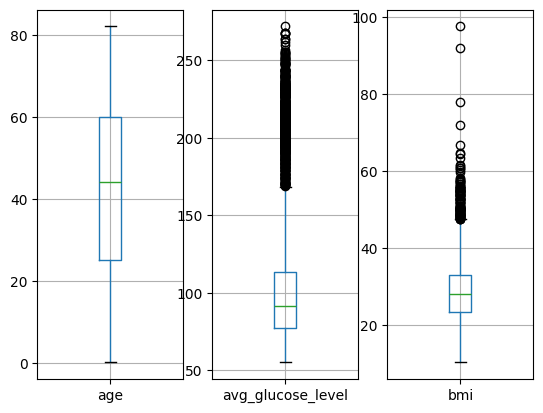

   hypertension  heart_disease  stroke  gender_Female  gender_Male  married  \
0             0              1       1              0            1        1   
1             1              1       1              0            1        1   
2             0              0       1              1            0        0   
3             0              0       1              1            0        1   
4             1              0       1              1            0        1   

   residence_urban  smoking_formerly  smoking_never  smoking_yes       age  \
0                0                 0              1            0  1.756023   
1                0                 0              1            0  1.488655   
2                1                 0              1            0  1.265849   
3                1                 0              0            0  1.666900   
4                0                 0              1            0  1.800584   

   avg_glucose_level       bmi  
0           0.634200  0

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
  
def removeOutliers(data, features):
  # Visualize outliers with boxplot
  for i, feature in enumerate(features, 1):
    plt.subplot(1,len(features),i)
    data[[feature]].boxplot()
  plt.show()
  
  # Find the index of observations to be removed
  removeIdx = pd.Series([False] * len(data))
  for feature in features:
    # Find the min and max value range of each feature
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    min = q1 - 1.5 * (q3 - q1)
    max = q3 + 1.5 * (q3 - q1)
    
    outliers_lower = data[feature] < min
    outliers_upper = data[feature] > max
    
    removeIdx = removeIdx | outliers_lower | outliers_upper

  return data.loc[~removeIdx]


data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Clean missing values, which only appear in BMI column
noBMI = np.isnan(data["bmi"])
data = data.loc[~noBMI]
data = data.reset_index(drop=True)

# Remove outliers
data = removeOutliers(data, ["age", "avg_glucose_level", "bmi"])
data = data.reset_index(drop=True)

# Drop unnecessary features
data = data.drop(columns=["id", "work_type"])

# One-hot-encoding some features
data = pd.get_dummies(data, columns=["gender", "ever_married", "Residence_type", "smoking_status"], dtype=int)
data = data.drop(columns=["gender_Other", "ever_married_No", "Residence_type_Rural", "smoking_status_Unknown"])
data = data.rename(
  columns={"ever_married_Yes": "married", 
           "Residence_type_Urban": "residence_urban",
           "smoking_status_formerly smoked": "smoking_formerly",
           "smoking_status_never smoked": "smoking_never",
           "smoking_status_smokes": "smoking_yes"
          }
)

# Standardize numerical features
numerical_features = ["age", "avg_glucose_level", "bmi"]
numerical_values = data[numerical_features]
scaler = StandardScaler()
numerical_values = scaler.fit_transform(numerical_values)
numerical_values = pd.DataFrame(numerical_values)
numerical_values.columns = numerical_features

data = data.drop(columns=numerical_features)
data = pd.concat([data, numerical_values], axis=1)

print(data.head())

Implementing Neural Network model with Grid Search:

In [6]:
from sklearn.model_selection import train_test_split
from keras import Sequential, layers, losses
import keras_tuner


data = pd.read_csv("ProcessedData.csv")

# Splitting data into training and testing set
x = data.drop(columns=["stroke"])
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=27)


def nnModel(hp):
  model = Sequential()
  model.add(layers.Input(shape=(12,)))
  
  # Hidden layers
  for i in range(hp.Int('num_layers', 1, 2)):
    model.add(
      layers.Dense(
        units=hp.Choice('units', [16, 32]), 
        activation=hp.Choice('activation', ['relu', 'tanh'])
      )
    )
    
  model.add(layers.Dense(2, "sigmoid"))
  model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  return model

# Grid search
tuner = keras_tuner.GridSearch(
  hypermodel=nnModel,
  objective='val_accuracy',
  overwrite="true",
  directory="neural_network",
  project_name="history"
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

models = tuner.get_best_models()
best_model = models[0]
best_model.summary()

# best_model.save('neural_network/best_model.keras')

Trial 8 Complete [00h 00m 04s]
val_accuracy: 0.9648093581199646

Best val_accuracy So Far: 0.9648093581199646
Total elapsed time: 00h 00m 29s


c:\Users\locng\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242 (968.00 B)

 Trainable params: 242 (968.00 B)

 Non-trainable params: 0 (0.00 B)

Comparing models:

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import keras


data = pd.read_csv("ProcessedData.csv")

# Splitting data into training and testing set
x = data.drop(columns=["stroke"])
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=27)


# Logistic Regression model
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Logistic Regression accuracy: ", accuracy_score(y_test, y_pred))


# Neural network model
nn: Sequential = keras.models.load_model('neural_network/best_model.keras')
y_pred = nn.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Neural Network accuracy: ", accuracy_score(y_test, y_pred))

Logistic Regression accuracy:  0.9636150234741784
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network accuracy:  0.9636150234741784


c:\Users\locng\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
